# **ASR Model**

Install Dependencies

In [ ]:
# SECTION 1 — Install Whisper + Torch
!pip install -q openai-whisper jiwer
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 41.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 113.9 MB/s eta 0:00:00


Imports + Mount Google Drive

In [ ]:
# SECTION 2 - Connect to google drive
import os, zipfile, shutil, json, re, math
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from jiwer import wer
import whisper
from collections import Counter

!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Set Base Paths + Extract Scripts ZIP

In [ ]:
# SECTION 3 — Define Base Paths and Extract Script Files
BASE_DRIVE_DIR = "/content/drive/MyDrive/SeniorProject"
ASR_OUTPUT_DIR = f"{BASE_DRIVE_DIR}/ASROUTPUT"

CALLS_DIR   = f"{BASE_DRIVE_DIR}/calls"
SCRIPTS_ZIP = f"{BASE_DRIVE_DIR}/scripts.zip"
SCRIPTS_DIR = "/content/scripts"

!rm -rf /content/scripts
!mkdir /content/scripts

print("Extracting scripts.zip ...")
!unzip -o "{SCRIPTS_ZIP}" -d "{SCRIPTS_DIR}" > /dev/null
print("Extraction complete.\n")

for root, dirs, files in os.walk(SCRIPTS_DIR):
    print("ROOT:", root)
    print("DIRS:", dirs)
    print("FILES:", files[:10])
    print("--------------------------------------------------")

SCRIPTS_DIR = "/content/scripts/scripts"


Extracting scripts.zip ...
Extraction complete.

ROOT: /content/scripts
DIRS: ['scripts']
FILES: []
--------------------------------------------------
ROOT: /content/scripts/scripts
DIRS: []
FILES: ['script_1477.json', 'script_1311.json', 'script_181.json', 'script_1357.json', 'script_272.json', 'script_1142_safe.json', 'script_1487.json', 'script_1491.json', 'script_1368.json', 'script_1486.json']
--------------------------------------------------


Utility Functions (Extract & Clean IDs)

In [ ]:
# SECTION 4 — ID Extraction + Fixing
def extract_id_from_name(name):
    name = str(name)
    digits = "".join(c for c in name if c.isdigit())
    return int(digits) if digits else None


def extract_call_id_from_audio(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    parts = base.split("_")
    for part in parts:
        digits = "".join(c for c in part if c.isdigit())
        if digits:
            return int(digits)
    return None


def clean_id(raw_id):
    """
    Fix IDs that end with an extra '2'.
    Example: 15662 → 1566
    """
    if raw_id is None:
        return None

    raw = str(raw_id)
    if len(raw) == 5 and raw.endswith("2"):
        return int(raw[:-1])

    return int(raw)


Map Audio Files to IDs

In [ ]:
# SECTION 5 — Map Audio Files by Call ID
AUDIO_EXTS = [".wav", ".mp3", ".m4a", ".flac"]

audio_by_id = {}
dup_audio_ids = []

for root, dirs, files in os.walk(CALLS_DIR):
    for f in files:
        ext = os.path.splitext(f)[1].lower()
        if ext in AUDIO_EXTS:
            cid = extract_call_id_from_audio(f)
            cid = clean_id(cid)
            if cid is None:
                continue
            full_path = os.path.join(root, f)
            if cid in audio_by_id:
                dup_audio_ids.append((cid, audio_by_id[cid], full_path))
            audio_by_id[cid] = full_path

print("Audio files mapped by ID:", len(audio_by_id))
print("Duplicate audio IDs:", len(dup_audio_ids))


Audio files mapped by ID: 1570
Duplicate audio IDs: 0


Map Script JSONs to IDs

In [ ]:
# SECTION 6 — Map JSON Script Files by Call ID
scripts_by_id = {}

for root, dirs, files in os.walk(SCRIPTS_DIR):
    for f in files:
        if f.lower().endswith(".json"):
            cid = extract_id_from_name(f)
            cid = clean_id(cid)
            if cid is not None:
                scripts_by_id[cid] = os.path.join(root, f)

print("Script JSONs mapped by ID:", len(scripts_by_id))


Script JSONs mapped by ID: 1570


Compare IDs (Audio vs Scripts vs Metadata)

In [ ]:
# SECTION 7 — Compare IDs (Audio vs Script)
audio_ids = set(audio_by_id.keys())
script_ids = set(scripts_by_id.keys())

matched_ids = audio_ids.intersection(script_ids)
audio_only  = audio_ids - script_ids
script_only = script_ids - audio_ids

print("Matched IDs:", len(matched_ids))
print("Audio only without scripts:", len(audio_only))
print("Script only without audios:", len(script_only))


Matched IDs: 1570
Audio only without scripts: 0
Script only without audios: 0


Extract Ground-Truth Text

In [ ]:
# SECTION 8 — Extract Ground Truth Text from JSON Scripts
def extract_gt_text(data):
    if not isinstance(data, dict):
        return ""

    for key in ["dialogue", "conversation", "turns"]:
        if key in data and isinstance(data[key], list):
            texts = []
            for turn in data[key]:
                if isinstance(turn, dict):
                    t = turn.get("text") or turn.get("utterance") or ""
                    if t:
                        texts.append(str(t))
            if texts:
                return " ".join(texts).strip()

    for k in ["script", "text", "gt_text", "conversation"]:
        v = data.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()

    return ""


Build Ground Truth Dictionary

In [ ]:
# SECTION 9 — Build Ground Truth Dictionary (gt_by_id)
gt_by_id = {}
bad_json = 0

for cid, path in scripts_by_id.items():
    try:
        with open(path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
    except Exception:
        bad_json += 1
        continue

    text = extract_gt_text(data)
    if text:
        gt_by_id.setdefault(cid, text)

print("\nGT items (by ID):", len(gt_by_id))
print("Bad JSON skipped:", bad_json)



GT items (by ID): 1570
Bad JSON skipped: 0


Load Metadata CSV

In [ ]:
# SECTION 10 - Load original metadata
META_CSV = f"{BASE_DRIVE_DIR}/metadata(Sheet1).csv"

meta = pd.read_csv(META_CSV, encoding="utf-8")
print("Raw metadata rows:", len(meta))
print("Columns:", list(meta.columns))

if "call_id" not in meta.columns:
    if "Filename" in meta.columns:
        meta["call_id"] = meta["Filename"].apply(extract_id_from_name)
    else:
        raise ValueError("No 'call_id' or 'Filename' column found in metadata.")

meta["call_id"] = meta["call_id"].apply(extract_id_from_name)
meta = meta.dropna(subset=["call_id"])
meta["call_id"] = meta["call_id"].astype(int)

print("Metadata rows after cleaning:", len(meta))
print("Unique call_id in metadata:", meta["call_id"].nunique())

meta.head()


Raw metadata rows: 1570
Columns: ['id', 'Filename', 'Type', 'Label', 'Student', 'Dialect', 'Fraud_Type', 'Duration_sec', 'Audio_format', 'tts_voice', 'snr', 'source', 'version', 'date_created', 'asr_confidence', 'utterances_count', 'utterance_labels', 'validator']
Metadata rows after cleaning: 1570
Unique call_id in metadata: 1570


,id,Filename,Type,Label,Student,Dialect,Fraud_Type,Duration_sec,Audio_format,tts_voice,snr,source,version,date_created,asr_confidence,utterances_count,utterance_labels,validator,call_id
0,1.0,fraud_call_001.wav,synthetic,Fraud,Albatool,egyptian,identity_theft,51.83,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",15.0,generated,v1.0,2025-11-08,NaN,NaN,NaN,NaN,1
1,2.0,fraud_call_002.wav,synthetic,Fraud,Albatool,gulf,bank_credentials,47.86,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",10.0,generated,v1.0,2025-11-08,NaN,NaN,NaN,NaN,2
2,3.0,fraud_call_003.wav,synthetic,Fraud,Albatool,gulf,phishing,71.35,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",0.0,generated,v1.0,2025-11-08,NaN,NaN,NaN,NaN,3
3,4.0,fraud_call_004.wav,synthetic,Fraud,Albatool,egyptian,phishing,38.02,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",10.0,generated,v1.0,2025-11-08,NaN,NaN,NaN,NaN,4
4,5.0,fraud_call_005.wav,synthetic,Fraud,Albatool,levantine,phishing,29.52,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",10.0,generated,v1.0,2025-11-08,NaN,NaN,NaN,NaN,5


Prepare Output Folders (ASROUTPUT)

In [ ]:
# SECTION 11 — Create Output Folders in Google Drive
JSON_DIR     = f"{ASR_OUTPUT_DIR}/json"
TXT_DIR      = f"{ASR_OUTPUT_DIR}/txt"
SEGMENTS_DIR = f"{ASR_OUTPUT_DIR}/segments"

os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(TXT_DIR, exist_ok=True)
os.makedirs(SEGMENTS_DIR, exist_ok=True)
os.makedirs(ASR_OUTPUT_DIR, exist_ok=True)


Load Whisper Model

In [ ]:
# SECTION 12 — Load Whisper ASR Model
model = whisper.load_model("large-v3").cuda()
print("Whisper loaded on:", next(model.parameters()).device)

whisper_config = dict(
    language="ar",
    temperature=0,
    best_of=1,
    beam_size=5,
    fp16=True,
    condition_on_previous_text=False,
)


100%|██████████████████████████████████████| 2.88G/2.88G [00:09<00:00, 343MiB/s]


Whisper loaded on: cuda:0


Run ASR + Save Per-Call Outputs

In [ ]:
# SECTION 13 — Run ASR on All Calls + Save Per-Call Outputs
rows = []

no_audio_count = 0
whisper_fail_count = 0
no_gt_count = 0

for _, row in tqdm(meta.iterrows(), total=len(meta)):
    cid = row.get("call_id")
    if pd.isna(cid):
        continue
    cid = int(cid)

    audio_path = audio_by_id.get(cid)
    if not audio_path or not os.path.isfile(audio_path):
        no_audio_count += 1
        continue

    try:
        result = model.transcribe(audio_path, **whisper_config)
    except Exception as e:
        whisper_fail_count += 1
        print(f"[WARN] Whisper failed for id={cid}: {e}")
        continue

    asr_text = (result.get("text") or "").strip()
    segments = result.get("segments", []) or []

    meta_dict = row.to_dict()
    per_call_obj = {
        "call_id": cid,
        "filename": os.path.basename(audio_path),
        "asr_text": asr_text,
        "segments": segments,
        "meta": meta_dict,
    }

    gt_text = gt_by_id.get(cid)
    if gt_text:
        per_call_obj["gt_text"] = gt_text
        try:
            call_wer = wer(gt_text, asr_text)
        except:
            call_wer = None
    else:
        gt_text = None
        call_wer = None
        no_gt_count += 1

    if call_wer is not None:
        asr_conf = 1 - call_wer
    else:
        asr_conf = None

    per_call_obj["wer"] = call_wer
    per_call_obj["asr_confidence"] = asr_conf

    json_path = os.path.join(JSON_DIR, f"{cid}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(per_call_obj, f, ensure_ascii=False, indent=2)

    txt_path = os.path.join(TXT_DIR, f"{cid}.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(asr_text)

    seg_path = os.path.join(SEGMENTS_DIR, f"{cid}_segments.txt")
    with open(seg_path, "w", encoding="utf-8") as f:
        for seg in segments:
            start = seg.get("start")
            end = seg.get("end")
            text = seg.get("text", "")
            f.write(f"[{start:.2f} - {end:.2f}] {text}\n")

    out_row = meta_dict.copy()
    out_row["call_id"] = cid
    out_row["asr_text"] = asr_text
    out_row["utterances_count"] = len(segments)
    out_row["gt_text"] = gt_text
    out_row["wer"] = call_wer
    out_row["asr_confidence"] = asr_conf

    rows.append(out_row)

df_out = pd.DataFrame(rows)

print("\n================ ASR SUMMARY ================")
print("Total metadata rows (after cleaning):", len(meta))
print("Total rows in df_out (ASR done):", len(df_out))
print("Unique call_id in df_out:", df_out["call_id"].nunique())
print("No audio for these meta rows:", no_audio_count)
print("Whisper failures:", whisper_fail_count)
print("Rows without GT text:", no_gt_count)
print("=============================================")

df_out.head()


  0%|          | 0/1570 [00:00<?, ?it/s]


================ ASR SUMMARY ================
Total metadata rows (after cleaning): 1570
Total rows in df_out (ASR done): 1570
Unique call_id in df_out: 1570
No audio for these meta rows: 0
Whisper failures: 0
Rows without GT text: 0


,id,Filename,Type,Label,Student,Dialect,Fraud_Type,Duration_sec,Audio_format,tts_voice,...,version,date_created,asr_confidence,utterances_count,utterance_labels,validator,call_id,asr_text,gt_text,wer
0,1.0,fraud_call_001.wav,synthetic,Fraud,Albatool,egyptian,identity_theft,51.83,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",...,v1.0,2025-11-08,0.836538,19,NaN,NaN,1,السلام عليكم يا أفندم أنا من خدمة العملاء في ا...,السلام عليكم يا أفندم، أنا من خدمة العملاء في ...,0.163462
1,2.0,fraud_call_002.wav,synthetic,Fraud,Albatool,gulf,bank_credentials,47.86,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",...,v1.0,2025-11-08,0.707317,12,NaN,NaN,2,ألو، السلام عليكم، معاك موظف من خدمة العملاء ف...,ألو! السلام عليكم، معاك موظف من خدمة العملاء ف...,0.292683
2,3.0,fraud_call_003.wav,synthetic,Fraud,Albatool,gulf,phishing,71.35,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",...,v1.0,2025-11-08,0.500000,26,NaN,NaN,3,آلو، السلام عليكم معاك سيف من البنك فيه مشكلة ...,الو، السلام عليكم. معاك سيف من البنك. فيه مشكل...,0.500000
3,4.0,fraud_call_004.wav,synthetic,Fraud,Albatool,egyptian,phishing,38.02,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",...,v1.0,2025-11-08,0.640625,8,NaN,NaN,4,ألو، مساء الخير إحنا من البنك وبنراجع بيانات ح...,ألو، مساء الخير. إحنا من البنك وبنراجع بيانات ...,0.359375
4,5.0,fraud_call_005.wav,synthetic,Fraud,Albatool,levantine,phishing,29.52,.wav_16k_mono,"Agent: Viraj (Voice ID:P1bg08DkjqiVEzOn76yG), ...",...,v1.0,2025-11-08,0.830189,9,NaN,NaN,5,مرحبا، معك سمير من خدمة العملاء في البنك لازم ...,مرحبا، معك سمير من خدمة العملاء في البنك. لازم...,0.169811


Save Output (ASR)

In [ ]:
# SECTION 14 - Save Metadata
final_csv  = f"{ASR_OUTPUT_DIR}/metadata_after_ASR.csv"
final_xlsx = f"{ASR_OUTPUT_DIR}/metadata_after_ASR.xlsx"

df_out.to_csv(final_csv, index=False, encoding="utf-8")
df_out.to_excel(final_xlsx, index=False)

print("Final ASR saved:")
print(final_csv)
print(final_xlsx)

Final ASR saved:
/content/drive/MyDrive/SeniorProject/ASROUTPUT/metadata_after_ASR.csv
/content/drive/MyDrive/SeniorProject/ASROUTPUT/metadata_after_ASR.xlsx


Compute Global Average WER



In [ ]:
# SECTION 15 — Global WER Summary
# Load final ASR metadata
CSV_PATH = f"{ASR_OUTPUT_DIR}/metadata_after_ASR.csv"
df = pd.read_csv(CSV_PATH)


print("============== GLOBAL WER SUMMARY ==============")
print(f"Average WER  : {global_avg_wer:.4f}")
print(f"Median WER   : {global_median_wer:.4f}")
print(f"Min WER      : {global_min_wer:.4f}")
print(f"Max WER      : {global_max_wer:.4f}")
print("================================================\n")


============== GLOBAL WER SUMMARY ==============
Average WER  : 0.2722
Median WER   : 0.2586
Min WER      : 0.0633
Max WER      : 1.3810



## NLP MODEL

 Mount Google Drive



In [1]:

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Imports & Base Paths

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
#SECTION 1,2 — Imports & Base Paths

import os
import re
import math
import numpy as np
import pandas as pd

import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer plots
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["axes.grid"] = False

# ------------------------------------------------------------
# Base folder of ASR output on Google Drive
# This matches the screenshot: MyDrive / ASROUTPUT / SeniorProject
# ------------------------------------------------------------
BASE_DIR = "/content/drive/MyDrive/SeniorProject/ASROUTPUT"

# NEW: main NLP output folder on Drive
NLP_OUT_DIR = "/content/drive/MyDrive/SeniorProject/output_of_NLP"

# Sub-folders for organization
MODELS_DIR = f"{NLP_OUT_DIR}/models"
FIG_DIR    = f"{NLP_OUT_DIR}/figures"
TABLE_DIR  = f"{NLP_OUT_DIR}/tables"

# Create folders if they don't exist
for d in [NLP_OUT_DIR, MODELS_DIR, FIG_DIR, TABLE_DIR]:
    os.makedirs(d, exist_ok=True)

# ASR metadata + segments (same as before)
META_PATH = f"{BASE_DIR}/metadata_after_ASR.csv"
SEG_ZIP_PATH = f"{BASE_DIR}/segments.zip"
SEG_DIR = f"{BASE_DIR}/segments"

os.makedirs(SEG_DIR, exist_ok=True)


print("Using BASE_DIR:", BASE_DIR)
print("Metadata file:", META_PATH)
print("Segments folder:", SEG_DIR)

print("\nNumber of segment files:", len(os.listdir(SEG_DIR)))
print("Sample files:", os.listdir(SEG_DIR)[:10])

Using BASE_DIR: /content/drive/MyDrive/SeniorProject/ASROUTPUT
Metadata file: /content/drive/MyDrive/SeniorProject/ASROUTPUT/metadata_after_ASR.csv
Segments folder: /content/drive/MyDrive/SeniorProject/ASROUTPUT/segments

Number of segment files: 1570
Sample files: ['571_segments.txt', '572_segments.txt', '573_segments.txt', '574_segments.txt', '575_segments.txt', '576_segments.txt', '577_segments.txt', '578_segments.txt', '579_segments.txt', '580_segments.txt']


Load Metadata (Call-level Information)


In [ ]:
# SECTION 3 — Load Metadata (Call-level Information)

df_meta = pd.read_csv(META_PATH)

# Normalize label text
df_meta["Label"] = df_meta["Label"].astype(str).str.strip().str.lower()

print("Metadata shape:", df_meta.shape)
print(df_meta[["call_id", "Filename", "Label"]].head())

print("\n=== MAIN LABEL COUNTS ===")
print(df_meta["Label"].value_counts())
print("\n=== PERCENTAGES ===")
print((df_meta["Label"].value_counts(normalize=True) * 100).round(2))

if "Fraud_Type" in df_meta.columns:
    print("\n=== FRAUD TYPE DISTRIBUTION (fraud calls only) ===")
    print(df_meta[df_meta["Label"] == "fraud"]["Fraud_Type"].value_counts())

Metadata shape: (1570, 22)
   call_id            Filename  Label
0        1  fraud_call_001.wav  fraud
1        2  fraud_call_002.wav  fraud
2        3  fraud_call_003.wav  fraud
3        4  fraud_call_004.wav  fraud
4        5  fraud_call_005.wav  fraud

=== MAIN LABEL COUNTS ===
Label
fraud    785
safe     785
Name: count, dtype: int64

=== PERCENTAGES ===
Label
fraud    50.0
safe     50.0
Name: proportion, dtype: float64

=== FRAUD TYPE DISTRIBUTION (fraud calls only) ===
Fraud_Type
identity_theft                   136
investment                       134
bank_credentials                 133
phishing                         132
customer_service_fraud           128
lottery_fraud                    121
bank_account_protection_fraud      1
Name: count, dtype: int64


 Build Segment-Level Dataset


In [ ]:

# SECTION 4 — Build Segment-Level Dataset

segment_rows = []

def extract_call_id(name: str):
    """
    Extract numeric call_id from a filename.
    Example: 'call_123_segments.txt' -> 123
    """
    digits = "".join(ch for ch in str(name) if ch.isdigit())
    return int(digits) if digits else None

for fname in os.listdir(SEG_DIR):

    if not fname.lower().endswith(".txt"):
        continue

    call_id = extract_call_id(fname)
    if call_id is None:
        continue

    row_meta = df_meta[df_meta["call_id"] == call_id]
    if row_meta.empty:
        # No metadata row for this call_id
        continue

    row_meta = row_meta.iloc[0]
    label = row_meta["Label"]
    fraud_type = row_meta["Fraud_Type"] if "Fraud_Type" in df_meta.columns else None

    seg_path = os.path.join(SEG_DIR, fname)
    with open(seg_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    seg_index = 0
    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Remove timing prefix: [start - end] ...
        text = re.sub(r"^\[[^\]]+\]\s*", "", line).strip()
        if not text:
            continue

        seg_index += 1

        segment_rows.append({
            "call_id": call_id,
            "segment_index": seg_index,
            "segment_text": text,
            "Label": label,
            "Fraud_Type": fraud_type
        })

df_seg = pd.DataFrame(segment_rows)

print("\nSegment dataset shape:", df_seg.shape)
print(df_seg.head())

print("\nSegment-level label counts:")
print(df_seg["Label"].value_counts())


Segment dataset shape: (20919, 5)
   call_id  segment_index                                       segment_text  \
0      571              1  مرحبا، أنا من خدمة الزبائن، كيف يمكنني مساعدتك...   
1      571              2  مرحبا، أنا فقط أريد التأكد من أن طلبي للمنتجات...   
2      571              3                      بالطبع، يمكنني مساعدتك في ذلك   
3      571              4               هل يمكنك تزويدي برقم الطلب الخاص بك؟   
4      571              5                               نعم، الرقم هو 123456   

  Label Fraud_Type  
0  safe       none  
1  safe       none  
2  safe       none  
3  safe       none  
4  safe       none  

Segment-level label counts:
Label
fraud    10785
safe     10134
Name: count, dtype: int64


Prepare DataFrame for BERT (Segment-Level)


In [ ]:
#SECTION 5 — Prepare DataFrame for BERT (Segment-Level)

df_seg["Label"] = df_seg["Label"].astype(str).str.strip().str.lower()

# For convenience, we can also keep a 'transcript' column if needed
df_seg["transcript"] = df_seg["segment_text"].astype(str)

print("\nFinal df_seg shape:", df_seg.shape)
print(df_seg[["call_id", "segment_index", "Label", "segment_text"]].head())


Final df_seg shape: (20919, 6)
   call_id  segment_index Label  \
0      571              1  safe   
1      571              2  safe   
2      571              3  safe   
3      571              4  safe   
4      571              5  safe   

                                        segment_text  
0  مرحبا، أنا من خدمة الزبائن، كيف يمكنني مساعدتك...  
1  مرحبا، أنا فقط أريد التأكد من أن طلبي للمنتجات...  
2                      بالطبع، يمكنني مساعدتك في ذلك  
3               هل يمكنك تزويدي برقم الطلب الخاص بك؟  
4                               نعم، الرقم هو 123456  


 Encode Labels (Binary: fraud / safe)


In [ ]:
# SECTION 6 — Encode Labels (Binary: fraud / safe)

# We fix the mapping explicitly for clarity and consistency
label2id = {"fraud": 0, "safe": 1}
id2label = {v: k for k, v in label2id.items()}

df_seg["label_id"] = df_seg["Label"].map(label2id)

print("\nSegment-level label_id distribution:")
print(df_seg["label_id"].value_counts())

# Sanity check
print("\nlabel2id:", label2id)
print("id2label:", id2label)


Segment-level label_id distribution:
label_id
0    10785
1    10134
Name: count, dtype: int64

label2id: {'fraud': 0, 'safe': 1}
id2label: {0: 'fraud', 1: 'safe'}


Data Augmentation

In [ ]:
# Save a copy before augmentation
df_before_aug = df_seg.copy()


In [ ]:

# SECTION 6.2 — Data Augmentation (on segment-level)

import random

def synonym_replacement_ar(text: str) -> str:
    """
    Simple Arabic synonym replacement.
    We only replace a few important fraud-related tokens
    to keep the overall meaning very close.
    """
    synonyms = {
        "ايقاف": ["تعطيل", "وقف"],
        "حسابك": ["الحساب", "حسابكم"],
        "التحقق": ["التأكد", "الفحص"],
        "رمز": ["كود", "رمز التحقق"],
        "تحديث": ["تجديد", "تعديل"],
        "بياناتك": ["معلوماتك", "بيانات الحساب"],
    }

    for word, syns in synonyms.items():
        if word in text:
            # replace only the first occurrence to keep the sentence natural
            return text.replace(word, random.choice(syns), 1)
    return text


def random_deletion(text: str, p: float = 0.1) -> str:
    """
    Randomly delete some words with probability p.
    We keep it very small because we don't want to destroy
    the main meaning of fraud sentences.
    """
    words = text.split()
    if len(words) <= 3:
        # very short segments are not good candidates for deletion
        return text

    new_words = [w for w in words if random.random() > p]
    if not new_words:
        return text
    return " ".join(new_words)


def noise_injection(text: str) -> str:
    """
    Inject simple noise at the end of the sentence.
    This simulates ASR / user typing noise (extra punctuation).
    """
    noises = ["!!", "...", "؟"]
    if random.random() < 0.3:
        return text + random.choice(noises)
    return text


def augment_text(text: str) -> str:
    """
    Apply 1–2 random augmentation operations on a given text.
    This keeps diversity but preserves the core meaning.
    """
    funcs = [synonym_replacement_ar, random_deletion, noise_injection]
    aug_text = text

    # Choose 1 or 2 random transformations
    for f in random.sample(funcs, k=random.randint(1, 2)):
        aug_text = f(aug_text)

    return aug_text



# Apply augmentation ONLY on "fraud" segments to help balance
# the dataset and make the fraud model more robust.

AUG_PER_SEGMENT = 1   # how many augmented copies per fraud segment

fraud_df = df_seg[df_seg["Label"] == "fraud"].copy()
augmented_rows = []

print("\n[Augmentation] Original fraud segments:", len(fraud_df))

for _, row in fraud_df.iterrows():
    for _ in range(AUG_PER_SEGMENT):
        new_text = augment_text(str(row["segment_text"]))

        augmented_rows.append({
            "call_id": row["call_id"],
            "segment_index": row["segment_index"],
            "segment_text": new_text,
            "Label": row["Label"],
            "Fraud_Type": row.get("Fraud_Type", None),
            "label_id": row["label_id"]
        })

df_aug = pd.DataFrame(augmented_rows)
print("[Augmentation] New augmented fraud segments:", len(df_aug))

# Concatenate original + augmented
df_seg = pd.concat([df_seg, df_aug], ignore_index=True)

# Optional: shuffle after augmentation
df_seg = df_seg.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n[Augmentation] Dataset size after augmentation:", df_seg.shape)
print("[Augmentation] Label distribution after augmentation:")
print(df_seg["Label"].value_counts())



[Augmentation] Original fraud segments: 10785
[Augmentation] New augmented fraud segments: 10785

[Augmentation] Dataset size after augmentation: (31704, 7)
[Augmentation] Label distribution after augmentation:
Label
fraud    21570
safe     10134
Name: count, dtype: int64



[Data Viz] Label distribution after augmentation:
   Label  Count  Percent
0  fraud  21570    68.04
1   safe  10134    31.96
Saved: /content/drive/MyDrive/SeniorProject/output_of_NLP/figures/label_distribution_after_augmentation.png


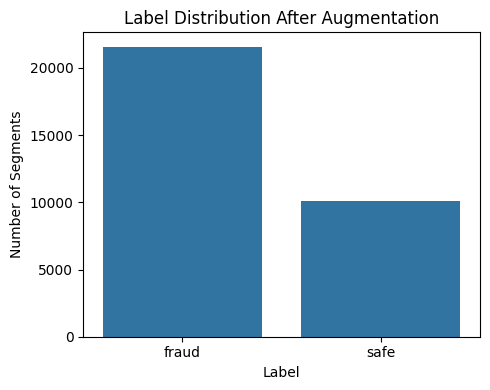


[Data Viz] Segment length stats:
count    31704.000000
mean         7.121783
std          3.655482
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         61.000000
Name: num_words, dtype: float64
Saved: /content/drive/MyDrive/SeniorProject/output_of_NLP/figures/segment_length_distribution_by_label.png


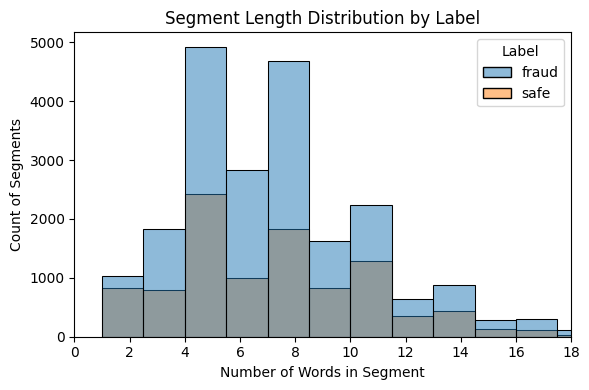

In [ ]:

# SECTION 6.3 — Data Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# Make sure we have a clean copy
df_viz = df_seg.copy()

# 1) Label distribution (fraud vs safe) AFTER augmentation
label_counts = df_viz["Label"].value_counts().reset_index()
label_counts.columns = ["Label", "Count"]
label_counts["Percent"] = (label_counts["Count"] / label_counts["Count"].sum() * 100).round(2)

print("\n[Data Viz] Label distribution after augmentation:")
print(label_counts)

plt.figure(figsize=(5, 4))
sns.barplot(data=label_counts, x="Label", y="Count")
plt.title("Label Distribution After Augmentation")
plt.xlabel("Label")
plt.ylabel("Number of Segments")
plt.tight_layout()

# Save figure to Drive (for the report)
try:
    plt.savefig(f"{FIG_DIR}/label_distribution_after_augmentation.png")
    print(f"Saved: {FIG_DIR}/label_distribution_after_augmentation.png")
except NameError:
    print("FIG_DIR not defined, figure not saved to Drive.")
plt.show()


# 2) Segment length distribution (number of words per segment)
df_viz["num_words"] = df_viz["segment_text"].astype(str).apply(lambda x: len(x.split()))

print("\n[Data Viz] Segment length stats:")
print(df_viz["num_words"].describe())

plt.figure(figsize=(6, 4))
sns.histplot(data=df_viz, x="num_words", hue="Label", bins=40, kde=False, multiple="layer")
plt.title("Segment Length Distribution by Label")
plt.xlabel("Number of Words in Segment")
plt.ylabel("Count of Segments")
plt.xlim(0, df_viz["num_words"].quantile(0.99))  # cut extreme outliers
plt.tight_layout()

# Save figure to Drive
try:
    plt.savefig(f"{FIG_DIR}/segment_length_distribution_by_label.png")
    print(f"Saved: {FIG_DIR}/segment_length_distribution_by_label.png")
except NameError:
    print("FIG_DIR not defined, figure not saved to Drive.")
plt.show()



[Data Viz] Comparison Before vs After Augmentation:
   Label  Count                Stage
0  fraud  10785  Before Augmentation
1   safe  10134  Before Augmentation
2  fraud  21570   After Augmentation
3   safe  10134   After Augmentation
Saved comparison figure to: /content/drive/MyDrive/SeniorProject/output_of_NLP/figures/before_vs_after_augmentation.png


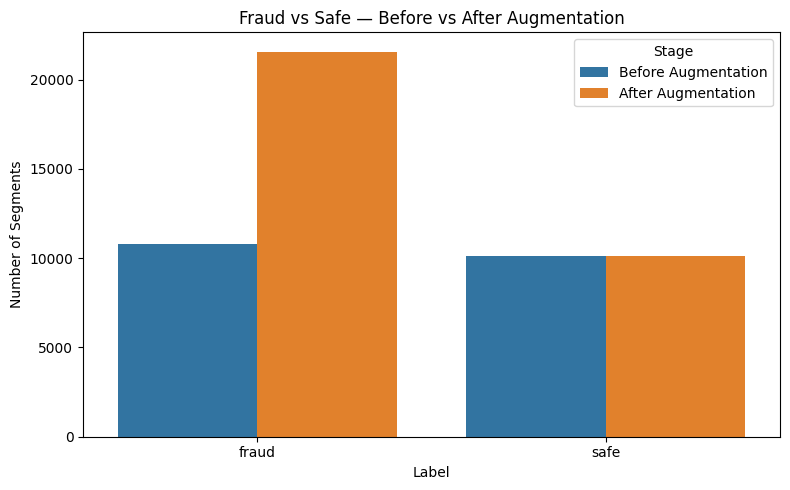

In [ ]:

# SECTION 6.3— Before vs After Augmentation (Comparison Figure)

import matplotlib.pyplot as plt
import seaborn as sns

# Count before augmentation
before_counts = df_before_aug["Label"].value_counts().reset_index()
before_counts.columns = ["Label", "Count"]
before_counts["Stage"] = "Before Augmentation"

# Count after augmentation
after_counts = df_seg["Label"].value_counts().reset_index()
after_counts.columns = ["Label", "Count"]
after_counts["Stage"] = "After Augmentation"

# Combine both
compare_df = pd.concat([before_counts, after_counts], ignore_index=True)

print("\n[Data Viz] Comparison Before vs After Augmentation:")
print(compare_df)

# Create side-by-side comparison figure
plt.figure(figsize=(8, 5))
sns.barplot(
    data=compare_df,
    x="Label",
    y="Count",
    hue="Stage"
)

plt.title("Fraud vs Safe — Before vs After Augmentation")
plt.xlabel("Label")
plt.ylabel("Number of Segments")
plt.tight_layout()

# Save figure to Drive
try:
    plt.savefig(f"{FIG_DIR}/before_vs_after_augmentation.png")
    print(f"Saved comparison figure to: {FIG_DIR}/before_vs_after_augmentation.png")
except NameError:
    print("FIG_DIR not defined, figure not saved.")

plt.show()


 Train/Test Split (Segment-Level)


In [ ]:
# SECTION 7 — Train/Test Split (Segment-Level)

train_df, test_df = train_test_split(
    df_seg,
    test_size=0.2,
    stratify=df_seg["label_id"],
    random_state=42
)

print("\nTrain size:", len(train_df))
print("Test size:", len(test_df))


Train size: 25363
Test size: 6341


 Build HuggingFace Datasets



In [ ]:
# SECTION 8 — Build HuggingFace Datasets

train_hf = Dataset.from_pandas(train_df[["segment_text", "label_id"]].reset_index(drop=True))
test_hf  = Dataset.from_pandas(test_df[["segment_text", "label_id"]].reset_index(drop=True))

print("\nHF Train dataset:", train_hf)
print("HF Test dataset:", test_hf)



HF Train dataset: Dataset({
    features: ['segment_text', 'label_id'],
    num_rows: 25363
})
HF Test dataset: Dataset({
    features: ['segment_text', 'label_id'],
    num_rows: 6341
})



 Metrics (Accuracy, Precision, Recall, F1 — Macro)


In [ ]:

# SECTION 9 — Metrics (Accuracy, Precision, Recall, F1 — Macro)

accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics from logits and true labels.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    accuracy  = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"]
    recall    = recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"]
    f1        = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]

    return {
        "accuracy": accuracy,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


 Model Training Helper

In [ ]:
# SECTION 10 — Model Training Helper
import os


from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

os.environ["WANDB_DISABLED"] = "true"

MAX_LENGTH = 256
BATCH_SIZE = 8
NUM_EPOCHS = 3

# Pre-trained Arabic models
models = {
    "AraBERT":   "aubmindlab/bert-base-arabertv02",
    "CAMeLBERT": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
    "MARBERT":   "UBC-NLP/MARBERT"
}

def train_eval_model(model_name: str, tag: str):
    """
    Fine-tune a given transformer model on the segment-level dataset.
    Returns y_true, y_pred, logits, and the metrics dictionary.
    """
    print(f"\n============================")
    print(f"TRAINING MODEL: {tag}")
    print("============================\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    # Tokenization function for HF Dataset
    def tokenize_fn(batch):
        return tokenizer(
            batch["segment_text"],
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH
        )

    train_tok = train_hf.map(tokenize_fn, batched=True)
    test_tok  = test_hf.map(tokenize_fn, batched=True)

    train_tok = train_tok.rename_column("label_id", "labels")
    test_tok  = test_tok.rename_column("label_id", "labels")

    train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


    training_args = TrainingArguments(
    # save HF checkpoints to Drive under models/
    output_dir=f"{MODELS_DIR}/{tag}_output",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_steps=50,

    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Predictions on test set
    preds_output = trainer.predict(test_tok)
    logits = preds_output.predictions
    y_pred = np.argmax(logits, axis=-1)
    y_true = preds_output.label_ids

    # Metrics dictionary returned by Trainer (contains eval_* keys)
    metrics = preds_output.metrics
    metrics["tag"] = tag
    metrics["model_name"] = model_name

    # final fine-tuned model directory (on Drive)
    save_dir = f"{MODELS_DIR}/{tag}_final"
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)



    print(f"\nSaved fine-tuned model to: {save_dir}")

    return y_true, y_pred, logits, metrics


 Train All Models (Segment-Level)

In [ ]:
# SECTION 11 — Train All Models (Segment-Level)

results = {}

for tag, path in models.items():
    print(f"\n===== Training {tag} =====")
    y_true, y_pred, logits, metrics = train_eval_model(path, tag)

    results[tag] = {
        "true": y_true,
        "pred": y_pred,
        "logits": logits,
        "metrics": metrics
    }


===== Training AraBERT =====

TRAINING MODEL: AraBERT



model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

 Segment-Level Reports + Confusion Matrices


SEGMENT-LEVEL CLASSIFICATION REPORT — AraBERT

              precision    recall  f1-score   support

       fraud       0.95      0.97      0.96      4314
        safe       0.92      0.88      0.90      2027

    accuracy                           0.94      6341
   macro avg       0.93      0.92      0.93      6341
weighted avg       0.94      0.94      0.94      6341



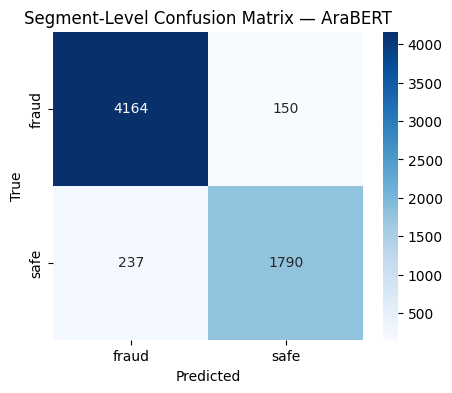


SEGMENT-LEVEL CLASSIFICATION REPORT — CAMeLBERT

              precision    recall  f1-score   support

       fraud       0.95      0.96      0.96      4314
        safe       0.92      0.89      0.90      2027

    accuracy                           0.94      6341
   macro avg       0.93      0.93      0.93      6341
weighted avg       0.94      0.94      0.94      6341



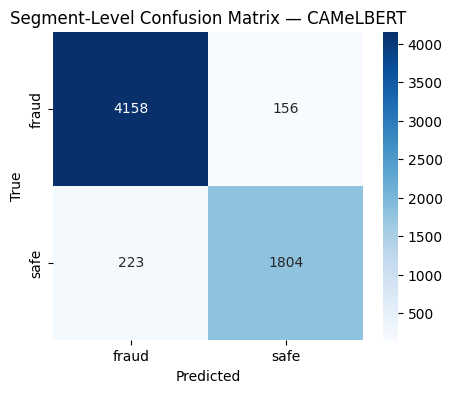


SEGMENT-LEVEL CLASSIFICATION REPORT — MARBERT

              precision    recall  f1-score   support

       fraud       0.95      0.96      0.96      4314
        safe       0.91      0.89      0.90      2027

    accuracy                           0.94      6341
   macro avg       0.93      0.93      0.93      6341
weighted avg       0.94      0.94      0.94      6341



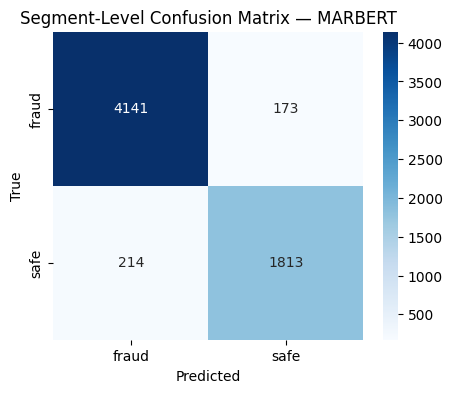

In [ ]:
 #SECTION 12 — Segment-Level Reports + Confusion Matrices

unique_labels = ["fraud", "safe"]

for tag in results.keys():
    print("\n==============================")
    print(f"SEGMENT-LEVEL CLASSIFICATION REPORT — {tag}")
    print("==============================\n")

    y_true = results[tag]["true"]
    y_pred = results[tag]["pred"]

    print(classification_report(y_true, y_pred, target_names=unique_labels))

    # Confusion Matrix (segment-level)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=unique_labels,
        yticklabels=unique_labels
    )
    plt.title(f"Segment-Level Confusion Matrix — {tag}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{FIG_DIR}/{tag}_segment_confusion.png")
    plt.show()


In [ ]:
# ===== COMBINED SEGMENT-LEVEL COMPARISON (one unified bar plot) =====

from sklearn.metrics import accuracy_score

segment_results = []  # Collect metrics for all models

for tag in results.keys():
    y_true = results[tag]["true"]
    y_pred = results[tag]["pred"]

    # Convert classification report to dict to extract numeric values
    report = classification_report(
        y_true,
        y_pred,
        target_names=unique_labels,
        output_dict=True
    )

    # Compute accuracy
    acc = accuracy_score(y_true, y_pred)

    # Extract F1-scores
    macro_f1 = report["macro avg"]["f1-score"]
    f1_fraud = report["fraud"]["f1-score"]
    f1_safe = report["safe"]["f1-score"]

    # Store results for this model
    segment_results.append({
        "Model": tag,
        "Accuracy": acc,
        "Macro_F1": macro_f1,
        "F1_fraud": f1_fraud,
        "F1_safe": f1_safe
    })

# Convert list to DataFrame
segment_df = pd.DataFrame(segment_results)

# Save comparison table
segment_df.to_csv(f"{TABLE_DIR}/segment_level_comparison.csv",
                  index=False, encoding="utf-8-sig")

print("\n====================================")
print("SEGMENT-LEVEL COMPARISON TABLE")
print("====================================\n")
print(segment_df)

# ===== Create unified bar plot (similar to voting comparison plot) =====

# Select columns to visualize (set Model as index)
segment_df_plot = segment_df.set_index("Model")[[
    "Accuracy", "Macro_F1", "F1_fraud", "F1_safe"
]]

# Plot a single bar chart comparing all models
ax = segment_df_plot.plot(kind="bar")
plt.title("Segment-Level Performance by Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.tight_layout()

# Save figure
plt.savefig(f"{FIG_DIR}/segment_level_comparison.png")
plt.show()


Weighted Call-Level Voting (Length + Confidence)


===== WEIGHTED Call-Level Voting for AraBERT =====
Weighted Call-level accuracy for AraBERT: 0.9792

--- CALL-LEVEL Weighted Classification Report ---
              precision    recall  f1-score   support

       fraud       0.96      1.00      0.98       773
        safe       1.00      0.96      0.98       715

    accuracy                           0.98      1488
   macro avg       0.98      0.98      0.98      1488
weighted avg       0.98      0.98      0.98      1488



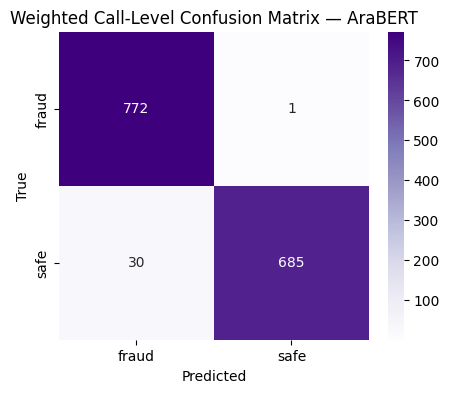


===== WEIGHTED Call-Level Voting for CAMeLBERT =====
Weighted Call-level accuracy for CAMeLBERT: 0.9785

--- CALL-LEVEL Weighted Classification Report ---
              precision    recall  f1-score   support

       fraud       0.96      1.00      0.98       773
        safe       1.00      0.96      0.98       715

    accuracy                           0.98      1488
   macro avg       0.98      0.98      0.98      1488
weighted avg       0.98      0.98      0.98      1488



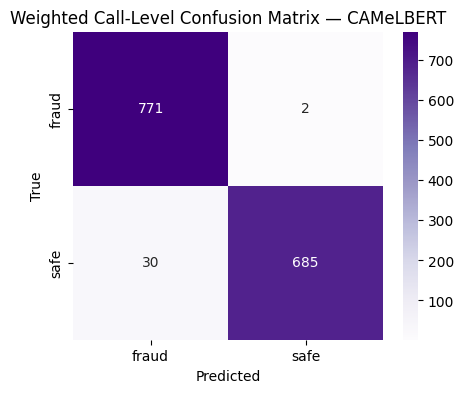


===== WEIGHTED Call-Level Voting for MARBERT =====
Weighted Call-level accuracy for MARBERT: 0.9778

--- CALL-LEVEL Weighted Classification Report ---
              precision    recall  f1-score   support

       fraud       0.96      0.99      0.98       773
        safe       0.99      0.96      0.98       715

    accuracy                           0.98      1488
   macro avg       0.98      0.98      0.98      1488
weighted avg       0.98      0.98      0.98      1488



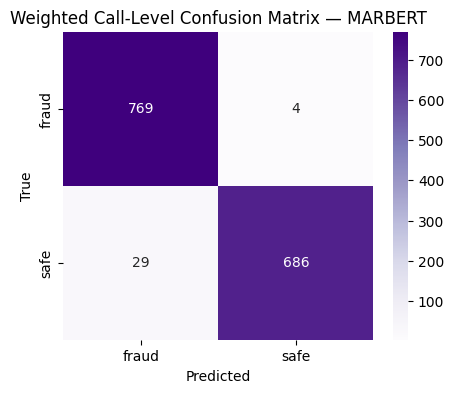

In [ ]:
# SECTION 13 — Weighted Call-Level Voting (Length + Confidence)

def softmax_np(x):
    """
    Numpy softmax helper for a single logit vector.
    """
    e = np.exp(x - np.max(x))
    return e / e.sum()

call_level_results = {}

for tag in results.keys():
    print(f"\n===== WEIGHTED Call-Level Voting for {tag} =====")

    y_true = results[tag]["true"]
    y_pred = results[tag]["pred"]
    logits = results[tag]["logits"]

    # Build temporary DataFrame for the test segments
    df_test_temp = test_df.copy().reset_index(drop=True)
    df_test_temp["true"] = y_true
    df_test_temp["pred"] = y_pred
    df_test_temp["logits"] = list(logits)

    final_true = {}
    final_pred = {}

    # Group by call_id to aggregate segment-level predictions
    for cid, group in df_test_temp.groupby("call_id"):

        # True label per call: majority label among its segments
        true_label = group["true"].mode()[0]
        final_true[cid] = true_label

        vote_scores = {}

        for _, row in group.iterrows():
            logit = row["logits"]
            probs = softmax_np(logit)

            # Confidence of the predicted class
            confidence = probs[row["pred"]]

            seg_text = row["segment_text"]
            length_weight = math.log(len(seg_text.split()) + 1)

            # Final weight = confidence * (1 + log(segment_length + 1))
            weight = confidence * (1 + length_weight)

            pred_label = row["pred"]
            vote_scores[pred_label] = vote_scores.get(pred_label, 0) + weight

        # Pick the class with the highest total score
        best_label = max(vote_scores, key=vote_scores.get)
        final_pred[cid] = best_label

    # Build call-level dataframe
    df_call = pd.DataFrame({
        "call_id": list(final_true.keys()),
        "true": list(final_true.values()),
        "pred": list(final_pred.values())
    })

    call_level_results[tag] = df_call

    # Accuracy
    acc = (df_call["true"] == df_call["pred"]).mean()
    print(f"Weighted Call-level accuracy for {tag}: {acc:.4f}")

    # Classification report
    print("\n--- CALL-LEVEL Weighted Classification Report ---")
    print(classification_report(
        df_call["true"],
        df_call["pred"],
        target_names=unique_labels
    ))

    # Confusion Matrix (call-level, weighted)
    cm = confusion_matrix(df_call["true"], df_call["pred"])
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Purples",
        xticklabels=unique_labels,
        yticklabels=unique_labels
    )
    plt.title(f"Weighted Call-Level Confusion Matrix — {tag}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{FIG_DIR}/{tag}_call_weighted_confusion.png")
    plt.show()


Voting Methods: Simple vs Weighted vs Threshold


VOTING METHODS — AraBERT

AraBERT — Acc(Simple)=0.9610, Acc(WeightedProb)=0.9792, Acc(Thresh@60%)=0.9882

VOTING METHODS — CAMeLBERT

CAMeLBERT — Acc(Simple)=0.9624, Acc(WeightedProb)=0.9798, Acc(Thresh@60%)=0.9868

VOTING METHODS — MARBERT

MARBERT — Acc(Simple)=0.9651, Acc(WeightedProb)=0.9792, Acc(Thresh@60%)=0.9883

VOTING COMPARISON TABLE

       Model  Simple Majority Acc  Weighted Prob Acc  Threshold@60 Acc  \
0    AraBERT               0.9610             0.9792            0.9882   
1  CAMeLBERT               0.9624             0.9798            0.9868   
2    MARBERT               0.9651             0.9792            0.9883   

   Rejected Calls  
0              45  
1              44  
2              39  


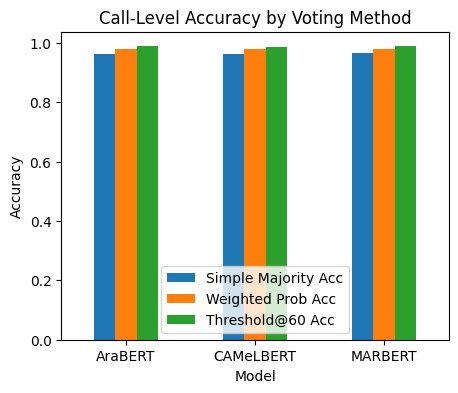

In [ ]:
# SECTION 14 — Voting Methods: Simple vs Weighted vs Threshold

from scipy.special import softmax as softmax_sp

voting_results = []

for tag in results.keys():
    print("\n==============================")
    print(f"VOTING METHODS — {tag}")
    print("==============================")

    y_true = results[tag]["true"]
    y_pred = results[tag]["pred"]
    logits = results[tag]["logits"]

    df_test_temp = test_df.copy().reset_index(drop=True)
    df_test_temp["true"] = y_true
    df_test_temp["pred"] = y_pred
    df_test_temp["logits"] = list(logits)

    # ---------- 1) SIMPLE MAJORITY ----------
    simple_true = {}
    simple_pred = {}

    for cid, group in df_test_temp.groupby("call_id"):
        true_label = group["true"].mode()[0]
        simple_true[cid] = true_label

        preds = list(group["pred"])
        voted = max(set(preds), key=preds.count)
        simple_pred[cid] = voted

    df_simple = pd.DataFrame({
        "call_id": list(simple_true.keys()),
        "true": list(simple_true.values()),
        "pred": list(simple_pred.values())
    })

    acc_simple = accuracy_score(df_simple["true"], df_simple["pred"])

    # ---------- 2) WEIGHTED (Probabilities Sum) ----------
    weighted_true = {}
    weighted_pred = {}

    for cid, group in df_test_temp.groupby("call_id"):
        true_label = group["true"].mode()[0]
        weighted_true[cid] = true_label

        prob_sum = np.zeros(len(label2id))

        for logit in group["logits"]:
            prob_sum += softmax_sp(logit)

        voted_class = np.argmax(prob_sum)
        weighted_pred[cid] = voted_class

    df_weighted = pd.DataFrame({
        "call_id": list(weighted_true.keys()),
        "true": list(weighted_true.values()),
        "pred": list(weighted_pred.values())
    })

    acc_weighted = accuracy_score(df_weighted["true"], df_weighted["pred"])

    # ---------- 3) THRESHOLD VOTING ----------
    threshold = 0.60  # You can adjust this value

    threshold_true = {}
    threshold_pred = {}

    for cid, group in df_test_temp.groupby("call_id"):

        true_label = group["true"].mode()[0]
        threshold_true[cid] = true_label

        prob_sum = np.zeros(len(label2id))
        for logit in group["logits"]:
            prob_sum += softmax_sp(logit)

        probs = prob_sum / prob_sum.sum()
        best_cls = np.argmax(probs)
        confidence = probs[best_cls]

        if confidence >= threshold:
            threshold_pred[cid] = best_cls
        else:
            threshold_pred[cid] = -1   # Unknown / rejected

    df_thresh = pd.DataFrame({
        "call_id": list(threshold_true.keys()),
        "true": list(threshold_true.values()),
        "pred": list(threshold_pred.values())
    })

    df_eval = df_thresh[df_thresh["pred"] != -1]
    acc_thresh = accuracy_score(df_eval["true"], df_eval["pred"])

    print(f"\n{tag} — Acc(Simple)={acc_simple:.4f}, "
          f"Acc(WeightedProb)={acc_weighted:.4f}, "
          f"Acc(Thresh@{int(threshold*100)}%)={acc_thresh:.4f}")

    voting_results.append({
        "Model": tag,
        "Simple Majority Acc": round(acc_simple, 4),
        "Weighted Prob Acc": round(acc_weighted, 4),
        "Threshold@60 Acc": round(acc_thresh, 4),
        "Rejected Calls": int((df_thresh["pred"] == -1).sum())
    })

voting_df = pd.DataFrame(voting_results)
print("\n====================================")
print("VOTING COMPARISON TABLE")
print("====================================\n")
print(voting_df)

# Save voting comparison table
voting_df.to_csv(f"{TABLE_DIR}/voting_comparison.csv",
                 index=False, encoding="utf-8-sig")


# Optional: bar plot for voting accuracies (nice for the report)
voting_df_plot = voting_df.set_index("Model")[["Simple Majority Acc", "Weighted Prob Acc", "Threshold@60 Acc"]]
voting_df_plot.plot(kind="bar")
plt.title("Call-Level Accuracy by Voting Method")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.savefig(f"{FIG_DIR}/voting_accuracy_comparison.png")
plt.show()


 Final Model Comparison (Segment vs Call-Level)

{'test_loss': 0.2800910174846649, 'test_accuracy': 0.9392840246017978, 'test_precision_macro': 0.934323307427207, 'test_recall_macro': 0.9250396078530931, 'test_f1_macro': 0.9294636788299445, 'test_runtime': 13.0161, 'test_samples_per_second': 487.166, 'test_steps_per_second': 60.925, 'tag': 'AraBERT', 'model_name': 'aubmindlab/bert-base-arabertv02'}
{'test_loss': 0.29913944005966187, 'test_accuracy': 0.9388109131051885, 'test_precision_macro': 0.9331473201544487, 'test_recall_macro': 0.9252149756680731, 'test_f1_macro': 0.9290205461525644, 'test_runtime': 14.6014, 'test_samples_per_second': 434.274, 'test_steps_per_second': 54.31, 'tag': 'CAMeLBERT', 'model_name': 'CAMeL-Lab/bert-base-arabic-camelbert-mix'}
{'test_loss': 0.31153184175491333, 'test_accuracy': 0.939441728434001, 'test_precision_macro': 0.9330090399345924, 'test_recall_macro': 0.9269862649319948, 'test_f1_macro': 0.9299041723377943, 'test_runtime': 14.0005, 'test_samples_per_second': 452.913, 'test_steps_per_second': 56.

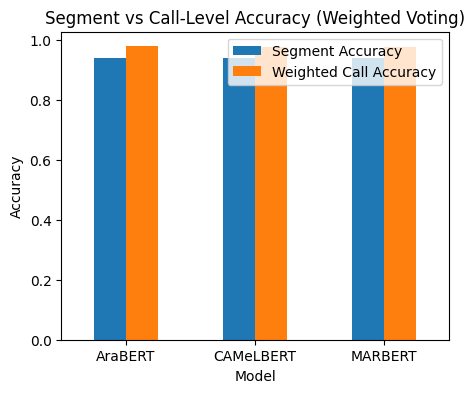

In [ ]:

# SECTION 15 — Final Model Comparison (Segment vs Call-Level)

comparison_rows = []

for tag in results.keys():

    seg_metrics = results[tag]["metrics"]
    print(seg_metrics)

    # Helper to safely read metrics from either eval_* أو test_*
    def get_seg_metric(base_name):
        return seg_metrics.get(f"eval_{base_name}",
               seg_metrics.get(f"test_{base_name}", float("nan")))

    seg_acc  = get_seg_metric("accuracy")
    seg_f1   = get_seg_metric("f1_macro")
    seg_prec = get_seg_metric("precision_macro")
    seg_rec  = get_seg_metric("recall_macro")

    df_call = call_level_results[tag]
    call_acc = (df_call["true"] == df_call["pred"]).mean()

    p, r, f1, _ = precision_recall_fscore_support(
        df_call["true"],
        df_call["pred"],
        average="macro",
        zero_division=0
    )

    comparison_rows.append({
        "Model": tag,
        "Segment Accuracy": round(float(seg_acc), 4),
        "Segment F1": round(float(seg_f1), 4),
        "Segment Precision": round(float(seg_prec), 4),
        "Segment Recall": round(float(seg_rec), 4),
        "Weighted Call Accuracy": round(float(call_acc), 4),
        "Weighted Call F1": round(float(f1), 4),
        "Weighted Call Precision": round(float(p), 4),
        "Weighted Call Recall": round(float(r), 4),
    })

comparison_df = pd.DataFrame(comparison_rows)

print("\n========================")
print("FINAL MODEL COMPARISON (Segment vs Call-Level)")
print("========================\n")
print(comparison_df)

# Save comparison table to Drive (for the report)
save_path = f"{TABLE_DIR}/model_comparison_results_weighted.csv"
comparison_df.to_csv(save_path, index=False, encoding="utf-8-sig")


print(f"\nSaved comparison table to:\n{save_path}")

# Optional: bar plot for segment vs call-level accuracy
comparison_df_plot = comparison_df.set_index("Model")[["Segment Accuracy", "Weighted Call Accuracy"]]
comparison_df_plot.plot(kind="bar")
plt.title("Segment vs Call-Level Accuracy (Weighted Voting)")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.savefig(f"{FIG_DIR}/segment_vs_call_accuracy.png")
plt.show()


 Fraud Risk Score per Call

In [ ]:
# SECTION 16 — Fraud Risk Score per Call

fraud_scores = {}
fraud_summary_rows = []

for tag in results.keys():

    print(f"\n--- Fraud Risk Score for {tag} ---")

    df_test_temp = test_df.copy().reset_index(drop=True)

    # Extract logits from results
    logits = results[tag]["logits"]  # shape: (num_segments, 2)

    # Convert logits → probabilities
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()  # (N, 2)

    # IMPORTANT: index 0 = 'fraud', index 1 = 'safe' (according to label2id)
    df_test_temp["p_fraud"] = probs[:, 0]
    df_test_temp["p_safe"]  = probs[:, 1]

    scores = []
    for cid, group in df_test_temp.groupby("call_id"):
        max_score = group["p_fraud"].max()        # maximum fraud probability among segments
        mean_score = group["p_fraud"].mean()      # average fraud probability across segments
        final_score = round((max_score * 0.7 + mean_score * 0.3), 4)

        scores.append({
            "call_id": cid,
            "Fraud_Risk_Score": final_score
        })

    df_scores = pd.DataFrame(scores)
    fraud_scores[tag] = df_scores

    fraud_summary_rows.append({
        "Model": tag,
        "Min_Risk": round(df_scores["Fraud_Risk_Score"].min(), 4),
        "Avg_Risk": round(df_scores["Fraud_Risk_Score"].mean(), 4),
        "Max_Risk": round(df_scores["Fraud_Risk_Score"].max(), 4),
        "Calls_Count": len(df_scores)
    })

    print(df_scores.head())

fraud_score_summary = pd.DataFrame(fraud_summary_rows)
print("\n=== FRAUD RISK SCORE SUMMARY ===")
print(fraud_score_summary)
# Save fraud risk summary
fraud_score_summary.to_csv(
    f"{TABLE_DIR}/fraud_risk_summary.csv",
    index=False, encoding="utf-8-sig"
)
# Save per-call fraud scores per model
for tag, df_scores in fraud_scores.items():
    df_scores.to_csv(
        f"{TABLE_DIR}/fraud_scores_{tag}.csv",
        index=False, encoding="utf-8-sig"
    )




--- Fraud Risk Score for AraBERT ---
   call_id  Fraud_Risk_Score
0        1            0.9982
1        2            0.9999
2        3            0.9624
3        4            0.9998
4        5            0.9998

--- Fraud Risk Score for CAMeLBERT ---
   call_id  Fraud_Risk_Score
0        1            0.9974
1        2            0.9999
2        3            0.9628
3        4            0.9998
4        5            0.9999

--- Fraud Risk Score for MARBERT ---
   call_id  Fraud_Risk_Score
0        1            0.9975
1        2            0.9998
2        3            0.9628
3        4            0.9997
4        5            0.9997

=== FRAUD RISK SCORE SUMMARY ===
       Model  Min_Risk  Avg_Risk  Max_Risk  Calls_Count
0    AraBERT    0.0002    0.6040    0.9999         1488
1  CAMeLBERT    0.0001    0.6017    0.9999         1488
2    MARBERT    0.0004    0.5938    0.9998         1488


In [ ]:
# ===== COMBINED FRAUD RISK SCORE COMPARISON (one unified plot) =====

# This section creates a single figure comparing all models
# using Min, Avg, and Max Fraud Risk Scores.

# Convert summary table (already computed above) to DataFrame
fraud_score_summary = pd.DataFrame(fraud_summary_rows)

# Save summary table (if not already saved)
fraud_score_summary.to_csv(
    f"{TABLE_DIR}/fraud_risk_summary.csv",
    index=False, encoding="utf-8-sig"
)

print("\n====================================")
print("FRAUD RISK SCORE — COMPARISON TABLE")
print("====================================\n")
print(fraud_score_summary)

# Set "Model" as index to prepare for plotting
fraud_plot_df = fraud_score_summary.set_index("Model")[[
    "Min_Risk", "Avg_Risk", "Max_Risk"
]]

# Create a unified bar plot comparing risk scores across models
ax = fraud_plot_df.plot(kind="bar")
plt.title("Fraud Risk Score Comparison by Model")
plt.ylabel("Fraud Risk Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.0)  # Risk probability range
plt.tight_layout()

# Save chart
plt.savefig(f"{FIG_DIR}/fraud_risk_score_comparison.png")
plt.show()


In [ ]:

# SECTION 16b — Summary: Average Fraud Risk Score by Model



print("\n[Summary] Average fraud risk per model:")
print(fraud_score_summary[["Model", "Avg_Risk"]])

plt.figure(figsize=(5, 4))
plt.bar(fraud_score_summary["Model"], fraud_score_summary["Avg_Risk"])

plt.ylim(0.0, 1.0)
plt.title("Average Fraud Risk Score by Model")
plt.xlabel("Model")
plt.ylabel("Average Fraud Risk Score")
plt.tight_layout()


plt.savefig(f"{FIG_DIR}/avg_fraud_risk_by_model.png", dpi=300)
plt.show()


Risk Levels (Low / Medium / High) + Distribution

/tmp/ipython-input-2761735633.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_risk, subset=["Risk_Level"])


,call_id,Fraud_Risk_Score,Risk_Level
0,1,1.00,High
1,2,1.00,High
2,3,0.96,High
3,4,1.00,High
4,5,1.00,High
5,6,1.00,High
6,7,1.00,High
7,8,1.00,High
8,9,0.98,High
9,10,1.00,High



=== RISK LEVEL DISTRIBUTION (CALL-LEVEL) ===
       Model  Low  Medium  High
0    AraBERT  554      16   918
1  CAMeLBERT  557      19   912
2    MARBERT  564      35   889


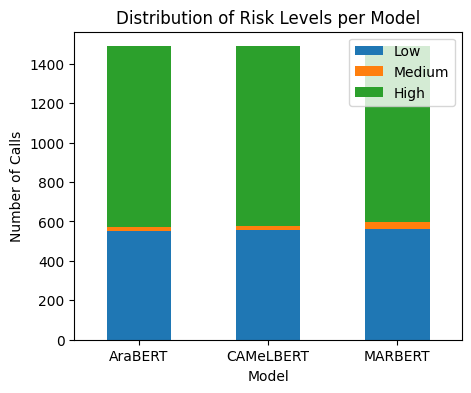

In [ ]:
# SECTION 17 — Risk Levels (Low / Medium / High) + Distribution

def risk_label(x):
    """
    Map continuous risk score to categorical risk level.
    Thresholds can be adjusted if needed.
    """
    if x < 0.4:
        return "Low"
    elif x < 0.7:
        return "Medium"
    else:
        return "High"

for tag in fraud_scores:
    fraud_scores[tag]["Risk_Level"] = fraud_scores[tag]["Fraud_Risk_Score"].apply(risk_label)

# Example: styled table for one model (CAMeLBERT) — nice for screenshots
def color_risk(val):
    if val == "High":
        return "background-color: #f8b4b4"   # light red
    elif val == "Medium":
        return "background-color: #ffe59a"   # light yellow
    else:
        return "background-color: #c7f5d9"   # light green

if "CAMeLBERT" in fraud_scores:
    styled_cam = (
        fraud_scores["CAMeLBERT"]
        .style
        .applymap(color_risk, subset=["Risk_Level"])
        .format({"Fraud_Risk_Score": "{:.2f}"})
    )
    # Display this in a notebook cell to see the colored table
    display(styled_cam)

# Build risk level distribution table
dist_rows = []
for tag in fraud_scores:
    counts = fraud_scores[tag]["Risk_Level"].value_counts()
    dist_rows.append({
        "Model": tag,
        "Low": counts.get("Low", 0),
        "Medium": counts.get("Medium", 0),
        "High": counts.get("High", 0)
    })

risk_distribution = pd.DataFrame(dist_rows)
print("\n=== RISK LEVEL DISTRIBUTION (CALL-LEVEL) ===")
print(risk_distribution)
# Save risk level distribution
risk_distribution.to_csv(
    f"{TABLE_DIR}/risk_level_distribution.csv",
    index=False, encoding="utf-8-sig"
)


# Bar plot for risk distribution (good for the report)
risk_distribution_plot = risk_distribution.set_index("Model")[["Low", "Medium", "High"]]
risk_distribution_plot.plot(kind="bar", stacked=True)
plt.title("Distribution of Risk Levels per Model")
plt.ylabel("Number of Calls")
plt.xticks(rotation=0)
plt.savefig(f"{FIG_DIR}/risk_level_distribution.png")
plt.show()

 Lexicon-Based Fraud Cues

In [ ]:
# SECTION 18 — Lexicon-Based Fraud Cues (Explainability)



FRAUD_LEXICON = {
    "phishing": [
        "تعطيل","تم إيقاف","حسابك","سيتم إغلاق","توثيق","التحقق","رمز","رمز التحقق",
        "الرمز","إعادة تفعيل","تحديث","تحديث البيانات","نحتاج نتحقق","رسالة","فتح الحساب",
        "تسجيل الدخول","معلوماتك","نؤكد هويتك","الهوية","مرفوض","رفض النظام"
    ],
    "bank_credentials": [
        "بطاقة","cvv","رقم البطاقة","رقم سري","الرقم السري","كلمة السر","تحويل","سحب","ايداع",
        "رصيد","حوالة","فاتورة","تفاصيل الحساب","حساب بنكي","بيانات البنك"
    ],
    "identity_theft": [
        "رقم الهوية","بطاقة الأحوال","رقم الإقامة","رقم السجل","إثبات","اثبات الهوية",
        "نسخة الهوية","ارسل هويتك"
    ],
    "customer_service": [
        "موظف البنك","خدمة العملاء","الدعم الفني","موظف حكومي","إدارة البنك","نحتاج بياناتك",
        "تصحيح البيانات","لدينا مشكلة","خطأ في النظام"
    ],
    "investment": [
        "عوائد","عوائد مضمونة","نسبة","استثمار","استثمر","أرباح","ربح سريع","دخل إضافي",
        "مبلغ بسيط","بدون خسارة","مكسب","عرض خاص","فرصة ذهبية","مضمون","80%"
    ],
    "lottery_prize": [
        "ربحت","جائزة","مبروك","سحب","فوز","هدية","مبلغ مالي","سحب الجوائز","الرقم الفائز"
    ],
    "threat": [
        "سيتم ايقاف","سيتم حظر","غرامة","بلاغ","مخالفة","تهديد","شرطة"
    ],
}

kw2type = {}
for cat, kws in FRAUD_LEXICON.items():
    for kw in kws:
        kw2type[kw] = cat

pattern = r'(' + '|'.join(map(re.escape, kw2type.keys())) + r')'

def analyze_keywords(text):
    """
    Highlight fraud-related keywords in the text and return:
    - marked_text: text with <<keyword>> around suspicious tokens
    - df: a DataFrame listing keyword, type, and count
    """
    found = []

    def repl(m):
        word = m.group(0)
        found.append(word)
        return f"<<{word}>>"

    marked = re.sub(pattern, repl, text)
    if not found:
        return marked, pd.DataFrame(columns=["keyword", "type", "count"])

    data = {}
    for w in found:
        data[w] = data.get(w, 0) + 1

    rows = []
    for w, c in data.items():
        rows.append({
            "keyword": w,
            "type": kw2type.get(w, "other"),
            "count": c
        })

    df_kw = pd.DataFrame(rows).sort_values(["type", "count"], ascending=[True, False])
    return marked, df_kw.reset_index(drop=True)

# Show a few random examples from the test set
df_test_temp = test_df.copy().reset_index(drop=True)
text_col = "segment_text"  # or "asr_text" if available

print("\n=== LEXICON-BASED FRAUD CUES (EXAMPLES) ===")
for i in range(min(5, len(df_test_temp))):
    txt = df_test_temp.iloc[i][text_col]
    marked, info_df = analyze_keywords(txt)

    print(f"\n========= SAMPLE {i+1} =========")
    print("Original:\n", txt)
    print("\nHighlighted:\n", marked)
    if len(info_df) == 0:
        print("\nNo fraud cues detected.")
    else:
        print("\nFraud cues table:")
        display(info_df)


=== LEXICON-BASED FRAUD CUES (EXAMPLES) ===

========= SAMPLE 1 =========
Original:
 بالطبع سأكون هنا لمساعدك لكن تأكد من أن الوقت مهم لحماية حسابك

Highlighted:
 بالطبع سأكون هنا لمساعدك لكن تأكد من أن الوقت مهم لحماية <<حسابك>>

Fraud cues table:


,keyword,type,count
0,حسابك,phishing,1



========= SAMPLE 2 =========
Original:
 يرجى التفكير بسرعة لأن الجائزة تحتاج للمطالبة بها خلال الساعات القادمة!!

Highlighted:
 يرجى التفكير بسرعة لأن ال<<جائزة>> تحتاج للمطالبة بها خلال الساعات القادمة!!

Fraud cues table:


,keyword,type,count
0,جائزة,lottery_prize,1



========= SAMPLE 3 =========
Original:
 الرقم هو وعنته 3456

Highlighted:
 الرقم هو وعنته 3456

No fraud cues detected.

========= SAMPLE 4 =========
Original:
 إذا لم نتأكد، قد يتعرض الحساب للاختراق

Highlighted:
 إذا لم نتأكد، قد يتعرض الحساب للاختراق

No fraud cues detected.

========= SAMPLE 5 =========
Original:
 لقد وصلني الرمز هو 700 نايت يورو فين باي

Highlighted:
 لقد وصلني <<الرمز>> هو 700 نايت يورو فين باي

Fraud cues table:


,keyword,type,count
0,الرمز,phishing,1


In [ ]:
import shutil
import os

# Source inside Colab runtime
src_fig = "/content/drive/MyDrive/SeniorProject/output_of_NLP/figures"
src_models = "/content/drive/MyDrive/SeniorProject/output_of_NLP/models"

# Destination inside Google Drive
dst_fig = "/content/drive/MyDrive/SeniorProject/output_of_NLP/figures"
dst_models = "/content/drive/MyDrive/SeniorProject/output_of_NLP/models"

# Create destination folders if missing
os.makedirs(dst_fig, exist_ok=True)
os.makedirs(dst_models, exist_ok=True)

# Move all figures
for file in os.listdir(src_fig):
    shutil.move(os.path.join(src_fig, file), os.path.join(dst_fig, file))

# Move all models
for file in os.listdir(src_models):
    shutil.move(os.path.join(src_models, file), os.path.join(dst_models, file))

print("All figures & models moved to Google Drive successfully!")


All figures & models moved to Google Drive successfully!
